# Kuramoto network brian
Galen & Marcel at Brian simulator:

https://brian.discourse.group/t/network-dynamics-visualizer/828/18

In [3]:
# code to make a network animation of Kuramoto node states over time and save as mp4

from matplotlib import pyplot as plt, animation
from matplotlib import colormaps
import networkx as nx
import numpy as np

from brian2 import *
defaultclock.dt = 1*ms


def run_sim(K, connection_matrix, runtime=10*second):
    '''
    run the Kuramoto simulation using a pre-determined network connectivity
    
    K is the coupling constant
    connection_matrix is the standard adjacency matrix
    runtime is the total runtime in seconds
    
    see: https://en.wikipedia.org/wiki/Kuramoto_model and the brian documentation
    '''
    
    # check for existence of 2-d square graph adjacency matrix
    assert connection_matrix.ndim == 2, "need 2D matrix"
    assert connection_matrix.shape[0] == connection_matrix.shape[1], "need quadratic matrix"
    N = connection_matrix.shape[0]

    # the Kuramoto dynamics
    eqs = '''
    dTheta/dt = omega + K/N*coupling : radian
    omega : radian/second (constant) # intrinsic frequency
    coupling : 1
    '''

    # create the oscillators
    oscillators = NeuronGroup(N, eqs, method='euler')
    oscillators.Theta = 'rand()*2*pi'  # random initial phase
    oscillators.omega = 'clip(3 + randn()*1, 0, inf)*radian/second'  # 𝒩(0.5, 0.5)

    # build the connections from the adjacency matrix
    connections = Synapses(oscillators, oscillators,
                        'coupling_post = sin(Theta_pre - Theta_post) : 1 (summed)')
    sources, targets = connection_matrix.nonzero()
    connections.connect(i=sources, j=targets)

    # monitor the node states
    mon = StateMonitor(oscillators, 'Theta', record=True)
    
    # actually run the simulation
    run(runtime)
    
    # return node states over time
    return mon.Theta[:]

def animate(frame):
    '''
    animate each frame of the simulation
    
    frame is one frame
    see matplotlib animation documentation
    '''
    
    # reset the figure
    fig.clear()
    
    # update the node states at each timestep
    time_step = int(round(frame*time_between_frames/defaultclock.dt))
    node_states = results.T[time_step] % (2*pi)

    # draw the network with node states
    nx.draw(G, pos, node_color = node_states, edgecolors = 'grey', 
            edge_color = 'lightgrey', cmap=colormaps['twilight'], vmin=0, vmax=2*np.pi)

<IPython.core.display.Javascript object>


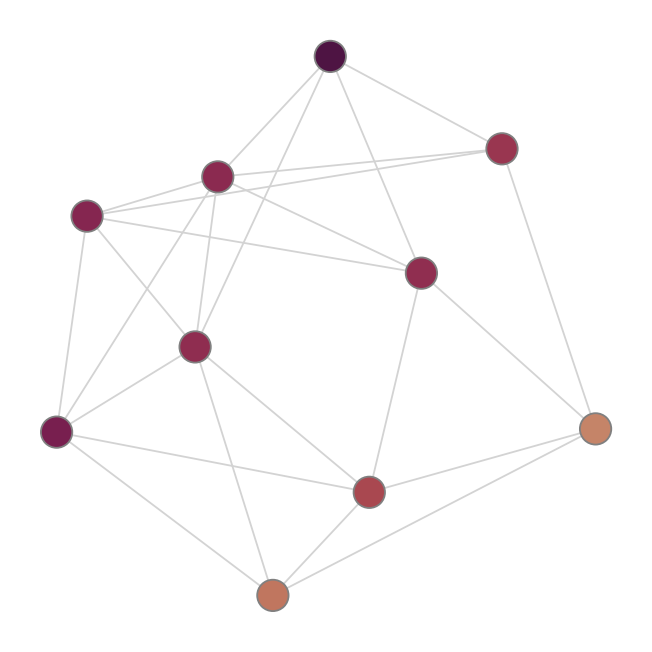

In [5]:
%matplotlib notebook 

plt.rcParams["figure.autolayout"] = True

# number of nodes ('neurons')
N = 10

# random unweighted adjacency matrix
num_weights = 2
A = np.random.randint(num_weights, size = [N,N])
A = np.triu(A, k = 1)  # keep only upper triangle

# create the networkx graph
G = nx.from_numpy_array(A)

##### NOTE, pos (DICTIONARY OF NODE POSITIONS) COULD BE REPLACED WITH ACTUALLY NEURON LOCATIONS, IF KNOWN
pos = nx.spring_layout(G)
fig = plt.figure(figsize=[5,5])

# run simulation with given adjacency matrix (network connectivity)
runtime = 10*second
results = run_sim(K=15/second, connection_matrix=A, runtime=runtime)

# length and speed
num_steps = 250
time_between_frames = runtime/num_steps

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=num_steps, interval=time_between_frames/ms, repeat=False)

plt.show()

# saving to m4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=25)
# anim.save('Kuramoto_network.mp4', writer=writervideo)
# plt.close()